# <font color='CC3D3D'> 0.5_8 Path_Embedding_Segmentation
    
- 대출 신청을 한 유저에 관한 경로 정보 path_applied_user.csv, 하지 않은 유저에 관한 경로 정보 path_no_applied_user.csv, 대출 신청 여부가 드러나 있지 않은 유저에 관한 경로 정보 path_null_applied_user.csv를 취합
- NLP 모델 Doc2Vec을 사용하여 경로 정보를 같은 길이로 임베딩한 뒤,
- 거리 기반의 KMeans 군집화 알고리즘을 사용하여 경로가 비슷한 6개의 그룹으로 구분
- 구분 데이터 <span style="color:blue"> **path_group.csv** </span> 생성

# Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from IPython.display import display
from numpy.typing import ArrayLike

import nltk
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import gc
import warnings

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)
nltk.download('punkt')
warnings.filterwarnings('ignore')
RANDOM_STATE = 52947

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Def

In [ ]:
def viewinfo(df:pd.DataFrame) -> None:
    print(df.shape)
    print()
    df.info()
    print()
    display(df.head(10))

In [ ]:
def minmax(series:ArrayLike) -> ArrayLike:
    maximum, minimum = series.max(), series.min()
    return (series-minimum) / (maximum-minimum)

# Data Load

In [ ]:
applied_path = pd.read_csv("../Data/path_applied_user.csv", engine='c', low_memory=True)
non_applied_path = pd.read_csv("../Data/path_no_applied_user.csv", engine='c', low_memory=True)
null_applied_path = pd.read_csv(f"../Data/path_null_applied_user.csv", engine='c', low_memory=True)
user = pd.read_csv("../Data/2022빅콘테스트_데이터분석리그_데이터분석분야_퓨처스부문_데이터셋_220908/user_spec.csv", engine='c',
                   dtype={'application_id': 'uint32', 'user_id': 'uint32'},
                   low_memory=True,
                   parse_dates=['insert_time'],
                   usecols=['application_id', 'user_id', 'insert_time'])

paths = pd.concat([applied_path, non_applied_path], axis=0)
viewinfo(paths)

(679996, 3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679996 entries, 0 to 323290
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   application_id  679996 non-null  int64 
 1   path            679996 non-null  object
 2   date_cd         679996 non-null  object
dtypes: int64(1), object(2)
memory usage: 20.8+ MB



,application_id,path,date_cd
0,871260,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...",2022-03-25
1,94017,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...",2022-03-25
2,1482636,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...",2022-03-25
3,1345169,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...",2022-03-25
4,75852,"('OpenApp', 'Login', 'UseLoanManage', 'GetCred...",2022-03-25
5,1563807,"('GetCreditInfo', 'UseLoanManage', 'GetCreditI...",2022-03-25
6,1803041,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...",2022-03-25
7,260091,"('EndLoanApply', 'ViewLoanApplyIntro', 'Comple...",2022-03-25
8,2089285,"('Login',)",2022-03-25
9,554652,"('StartLoanApply', 'ViewLoanApplyIntro', 'Open...",2022-03-25


In [ ]:
app_user_id = {user['application_id'].iloc[i]: user['user_id'].iloc[i] for i in range(user.shape[0])}

In [ ]:
paths['user_id'] = paths['application_id'].map(app_user_id)
paths = pd.concat([paths, null_applied_path], axis=0)
viewinfo(paths)

(1740729, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1740729 entries, 0 to 1060732
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   application_id  float64
 1   path            object 
 2   date_cd         object 
 3   user_id         int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 66.4+ MB



,application_id,path,date_cd,user_id
0,871260.0,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...",2022-03-25,72878
1,94017.0,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...",2022-03-25,618857
2,1482636.0,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...",2022-03-25,618857
3,1345169.0,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...",2022-03-25,496477
4,75852.0,"('OpenApp', 'Login', 'UseLoanManage', 'GetCred...",2022-03-25,217308
5,1563807.0,"('GetCreditInfo', 'UseLoanManage', 'GetCreditI...",2022-03-25,27667
6,1803041.0,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...",2022-03-25,831139
7,260091.0,"('EndLoanApply', 'ViewLoanApplyIntro', 'Comple...",2022-03-25,229879
8,2089285.0,"('Login',)",2022-03-25,193072
9,554652.0,"('StartLoanApply', 'ViewLoanApplyIntro', 'Open...",2022-03-25,102002


In [ ]:
unique_paths = pd.DataFrame({'path': paths['path'].unique()})

In [ ]:
## 전처리 0
event_dict = {
    'SignUp': 'sign up',
    'OpenApp': 'open app',
    'Login': 'login',
    'ViewLoanApplyIntro': 'view loan apply intro',
    'StartLoanApply': 'start loan apply',
    'CompleteIDCertification': 'complete id certification',
    'EndLoanApply': 'end loan apply',
    'UseLoanManage': 'use loan manage',
    'UsePrepayCalc': 'use prepay calculator',
    'UseDSRCalc': 'use debt service ratio calculator',
    'GetCreditInfo': 'get credit information'
}

## 전처리 1
unique_paths['processed'] = unique_paths['path'].map(lambda x: x[1:-1])
unique_paths['processed'] = unique_paths['processed'].map(lambda x: [item[1:-1].replace("'", "") for item in x.split(', ')])

## 전처리 2
unique_paths['processed'] = unique_paths['processed'].map(lambda x: ', '.join([event_dict[item] for item in x]))
unique_paths.head(10)

,path,processed
0,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...","login, start loan apply, view loan apply intro..."
1,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a..."
2,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a..."
3,"('OpenApp', 'Login', 'UseLoanManage', 'GetCred...","open app, login, use loan manage, get credit i..."
4,"('GetCreditInfo', 'UseLoanManage', 'GetCreditI...","get credit information, use loan manage, get c..."
5,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...","login, start loan apply, view loan apply intro..."
6,"('EndLoanApply', 'ViewLoanApplyIntro', 'Comple...","end loan apply, view loan apply intro, complet..."
7,"('Login',)",login
8,"('StartLoanApply', 'ViewLoanApplyIntro', 'Open...","start loan apply, view loan apply intro, open ..."
9,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a..."


In [ ]:
idx = 0
tagged_data = []
for path in tqdm(list(unique_paths['processed'])):
    tagged_data.append(TaggedDocument(words=word_tokenize(path.lower()), tags=[str(idx)]))
    idx += 1

print(len(tagged_data))
print(tagged_data[0])

100%|██████████| 277577/277577 [01:31<00:00, 3028.73it/s]

277577
TaggedDocument<['login', ',', 'start', 'loan', 'apply', ',', 'view', 'loan', 'apply', 'intro', ',', 'complete', 'id', 'certification', ',', 'end', 'loan', 'apply'], ['0']>


In [ ]:
max_epochs = 15
vector_size = 32
model = Doc2Vec(vector_size=vector_size)
model.build_vocab(tagged_data)

for epoch in tqdm(range(max_epochs)):
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

100%|██████████| 15/15 [1:22:03<00:00, 328.22s/it]


In [ ]:
model.save("../Model/d2v.model")
print("Model Saved")
model = Doc2Vec.load("../Model/d2v.model")
print("Model Loaded")

Model Saved
Model Loaded


In [ ]:
path_embed_dict = dict()
for path in tqdm(unique_paths['processed'].unique()):
    path_embed_dict[path] = model.infer_vector(word_tokenize(path.lower()))
unique_paths['embeddings'] = unique_paths['processed'].map(path_embed_dict)

100%|██████████| 277577/277577 [04:35<00:00, 1008.23it/s]


In [ ]:
vector_size = unique_paths['embeddings'].iloc[0].shape[0]
print(vector_size)

32


In [ ]:
components = []
for i in tqdm(range(vector_size)):
    item = [unique_paths['embeddings'].iloc[j][i] for j in range(unique_paths.shape[0])]
    components.append(item)

100%|██████████| 32/32 [01:25<00:00,  2.67s/it]


In [ ]:
for i, item in tqdm(enumerate(components)):
    unique_paths[f"Component{i+1}"] = item
viewinfo(unique_paths)

32it [00:02, 15.66it/s]


(277577, 35)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277577 entries, 0 to 277576
Data columns (total 35 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   path         277577 non-null  object 
 1   processed    277577 non-null  object 
 2   embeddings   277577 non-null  object 
 3   Component1   277577 non-null  float32
 4   Component2   277577 non-null  float32
 5   Component3   277577 non-null  float32
 6   Component4   277577 non-null  float32
 7   Component5   277577 non-null  float32
 8   Component6   277577 non-null  float32
 9   Component7   277577 non-null  float32
 10  Component8   277577 non-null  float32
 11  Component9   277577 non-null  float32
 12  Component10  277577 non-null  float32
 13  Component11  277577 non-null  float32
 14  Component12  277577 non-null  float32
 15  Component13  277577 non-null  float32
 16  Component14  277577 non-null  float32
 17  Component15  277577 non-null  float32
 18  Component1

,path,processed,embeddings,Component1,Component2,Component3,Component4,Component5,Component6,Component7,Component8,Component9,Component10,Component11,Component12,Component13,Component14,Component15,Component16,Component17,Component18,Component19,Component20,Component21,Component22,Component23,Component24,Component25,Component26,Component27,Component28,Component29,Component30,Component31,Component32
0,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...","login, start loan apply, view loan apply intro...","[0.06371364, -0.0027174007, -0.0043107932, 0.0...",0.063714,-0.002717,-0.004311,0.012863,0.078528,0.048433,0.002448,0.059343,-0.106630,-0.127839,-0.096116,0.042791,-0.055906,-0.107747,0.163747,-0.073270,0.097261,0.001194,0.183316,-0.056198,-0.026070,-0.010077,0.057767,-0.010817,0.034083,0.079074,-0.017282,0.132538,-0.119630,0.032354,-0.074276,-0.039071
1,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a...","[-0.006433299, -0.012349155, 0.042309713, -0.0...",-0.006433,-0.012349,0.042310,-0.074814,0.044032,-0.065241,-0.118317,-0.009805,0.055622,-0.178393,-0.182844,0.043743,0.108397,-0.119072,0.298776,-0.120180,-0.013808,-0.053277,0.283966,-0.279235,0.065307,-0.146740,0.032129,-0.095018,-0.030789,0.191273,-0.109182,0.206062,-0.282896,0.099974,0.008139,-0.049811
2,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a...","[0.054358125, 0.05631258, 0.024874503, -0.1075...",0.054358,0.056313,0.024875,-0.107599,0.041433,0.083705,-0.108054,-0.002760,0.043527,-0.046906,-0.040594,-0.091720,0.016219,0.024631,0.102074,-0.005710,-0.029763,-0.192161,0.161236,-0.206023,0.042199,-0.006985,0.001805,0.109591,0.070431,0.127238,0.021463,0.101687,-0.088881,0.006124,-0.071933,-0.029166
3,"('OpenApp', 'Login', 'UseLoanManage', 'GetCred...","open app, login, use loan manage, get credit i...","[0.031055167, 0.071985036, -0.03701398, -0.053...",0.031055,0.071985,-0.037014,-0.053014,0.026453,0.051383,-0.043500,0.150232,-0.094052,-0.091896,-0.067998,-0.044945,-0.012982,-0.010849,0.072978,-0.041215,0.052298,-0.030508,0.154652,-0.102043,-0.058035,0.039161,0.061158,-0.029621,0.043033,0.075030,0.043423,0.091814,-0.109135,0.073924,-0.042635,-0.049726
4,"('GetCreditInfo', 'UseLoanManage', 'GetCreditI...","get credit information, use loan manage, get c...","[0.050136328, 0.07081204, -0.0013531668, -0.07...",0.050136,0.070812,-0.001353,-0.073679,-0.031094,0.127502,-0.002303,0.097203,-0.041101,-0.062483,-0.059103,-0.107579,-0.044388,0.004592,-0.010163,-0.051874,0.005546,-0.097045,0.125011,-0.062713,-0.113314,0.129667,0.014687,0.111240,0.009607,0.124755,0.129615,0.046244,-0.049326,0.012907,-0.077644,-0.079021
5,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...","login, start loan apply, view loan apply intro...","[0.10427666, 0.011031533, -0.032765664, -0.050...",0.104277,0.011032,-0.032766,-0.050678,0.009463,0.047865,0.023726,-0.084342,0.012554,-0.168494,-0.097386,-0.081487,0.092587,-0.126993,0.128796,0.014674,0.144005,-0.100702,0.104164,-0.003518,0.016678,-0.114431,-0.102848,0.137504,0.035710,0.023495,0.054907,0.000656,-0.063511,-0.092066,-0.103760,-0.056617
6,"('EndLoanApply', 'ViewLoanApplyIntro', 'Comple...","end loan apply, view loan apply intro, complet...","[0.1052505, 0.06763772, 0.0043461267, 0.013259...",0.105251,0.067638,0.004346,0.013259,0.049477,-0.044369,0.059421,-0.017267,-0.067476,-0.153824,-0.142285,0.099692,-0.024039,-0.157745,0.087492,-0.010780,0.217738,0.010204,0.195356,-0.110219,-0.039211,-0.151496,0.042243,-0.061639,0.037335,0.105429,-0.062406,0.053244,-0.139738,0.043533,-0.021184,0.059896
7,"('Login',)",login,"[0.053232253, 0.07727824, -0.040143024, -0.052...",0.053232,0.077278,-0.040143,-0.052889,0.016104,0.018469,-0.052565,0.046599,-0.067784,-0.112384,-0.070892,-0.022191,-0.009099,0.002649,0.072151,0.024153,0.100830,-0.016991,0.137095,-0.060045,-0.055566,-0.062975,0.065279,0.012828,0.007876,0.055051,-0.023394,0.081747,-0.114850,0.027080,-0.057

In [ ]:
# for col in unique_paths.columns.values:
#     if "Component" in col:
#         unique_paths[col] = minmax(unique_paths[col])

In [ ]:
keep_keys= ['path', 'processed', 'embeddings']
to_keep = unique_paths[keep_keys]
to_use = unique_paths.drop(keep_keys, axis=1)

In [ ]:
viewinfo(to_keep)

(277577, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277577 entries, 0 to 277576
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   path        277577 non-null  object
 1   processed   277577 non-null  object
 2   embeddings  277577 non-null  object
dtypes: object(3)
memory usage: 6.4+ MB



,path,processed,embeddings
0,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...","login, start loan apply, view loan apply intro...","[0.06371364, -0.0027174007, -0.0043107932, 0.0..."
1,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a...","[-0.006433299, -0.012349155, 0.042309713, -0.0..."
2,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a...","[0.054358125, 0.05631258, 0.024874503, -0.1075..."
3,"('OpenApp', 'Login', 'UseLoanManage', 'GetCred...","open app, login, use loan manage, get credit i...","[0.031055167, 0.071985036, -0.03701398, -0.053..."
4,"('GetCreditInfo', 'UseLoanManage', 'GetCreditI...","get credit information, use loan manage, get c...","[0.050136328, 0.07081204, -0.0013531668, -0.07..."
5,"('Login', 'StartLoanApply', 'ViewLoanApplyIntr...","login, start loan apply, view loan apply intro...","[0.10427666, 0.011031533, -0.032765664, -0.050..."
6,"('EndLoanApply', 'ViewLoanApplyIntro', 'Comple...","end loan apply, view loan apply intro, complet...","[0.1052505, 0.06763772, 0.0043461267, 0.013259..."
7,"('Login',)",login,"[0.053232253, 0.07727824, -0.040143024, -0.052..."
8,"('StartLoanApply', 'ViewLoanApplyIntro', 'Open...","start loan apply, view loan apply intro, open ...","[-0.0016708188, 0.10211807, 0.018878523, -0.01..."
9,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo...","open app, login, start loan apply, view loan a...","[0.04850869, 0.13641827, -0.0004950871, 0.0082..."


In [ ]:
viewinfo(to_use)

(277577, 32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277577 entries, 0 to 277576
Data columns (total 32 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Component1   277577 non-null  float32
 1   Component2   277577 non-null  float32
 2   Component3   277577 non-null  float32
 3   Component4   277577 non-null  float32
 4   Component5   277577 non-null  float32
 5   Component6   277577 non-null  float32
 6   Component7   277577 non-null  float32
 7   Component8   277577 non-null  float32
 8   Component9   277577 non-null  float32
 9   Component10  277577 non-null  float32
 10  Component11  277577 non-null  float32
 11  Component12  277577 non-null  float32
 12  Component13  277577 non-null  float32
 13  Component14  277577 non-null  float32
 14  Component15  277577 non-null  float32
 15  Component16  277577 non-null  float32
 16  Component17  277577 non-null  float32
 17  Component18  277577 non-null  float32
 18  Component1

,Component1,Component2,Component3,Component4,Component5,Component6,Component7,Component8,Component9,Component10,Component11,Component12,Component13,Component14,Component15,Component16,Component17,Component18,Component19,Component20,Component21,Component22,Component23,Component24,Component25,Component26,Component27,Component28,Component29,Component30,Component31,Component32
0,0.063714,-0.002717,-0.004311,0.012863,0.078528,0.048433,0.002448,0.059343,-0.106630,-0.127839,-0.096116,0.042791,-0.055906,-0.107747,0.163747,-0.073270,0.097261,0.001194,0.183316,-0.056198,-0.026070,-0.010077,0.057767,-0.010817,0.034083,0.079074,-0.017282,0.132538,-0.119630,0.032354,-0.074276,-0.039071
1,-0.006433,-0.012349,0.042310,-0.074814,0.044032,-0.065241,-0.118317,-0.009805,0.055622,-0.178393,-0.182844,0.043743,0.108397,-0.119072,0.298776,-0.120180,-0.013808,-0.053277,0.283966,-0.279235,0.065307,-0.146740,0.032129,-0.095018,-0.030789,0.191273,-0.109182,0.206062,-0.282896,0.099974,0.008139,-0.049811
2,0.054358,0.056313,0.024875,-0.107599,0.041433,0.083705,-0.108054,-0.002760,0.043527,-0.046906,-0.040594,-0.091720,0.016219,0.024631,0.102074,-0.005710,-0.029763,-0.192161,0.161236,-0.206023,0.042199,-0.006985,0.001805,0.109591,0.070431,0.127238,0.021463,0.101687,-0.088881,0.006124,-0.071933,-0.029166
3,0.031055,0.071985,-0.037014,-0.053014,0.026453,0.051383,-0.043500,0.150232,-0.094052,-0.091896,-0.067998,-0.044945,-0.012982,-0.010849,0.072978,-0.041215,0.052298,-0.030508,0.154652,-0.102043,-0.058035,0.039161,0.061158,-0.029621,0.043033,0.075030,0.043423,0.091814,-0.109135,0.073924,-0.042635,-0.049726
4,0.050136,0.070812,-0.001353,-0.073679,-0.031094,0.127502,-0.002303,0.097203,-0.041101,-0.062483,-0.059103,-0.107579,-0.044388,0.004592,-0.010163,-0.051874,0.005546,-0.097045,0.125011,-0.062713,-0.113314,0.129667,0.014687,0.111240,0.009607,0.124755,0.129615,0.046244,-0.049326,0.012907,-0.077644,-0.079021
5,0.104277,0.011032,-0.032766,-0.050678,0.009463,0.047865,0.023726,-0.084342,0.012554,-0.168494,-0.097386,-0.081487,0.092587,-0.126993,0.128796,0.014674,0.144005,-0.100702,0.104164,-0.003518,0.016678,-0.114431,-0.102848,0.137504,0.035710,0.023495,0.054907,0.000656,-0.063511,-0.092066,-0.103760,-0.056617
6,0.105251,0.067638,0.004346,0.013259,0.049477,-0.044369,0.059421,-0.017267,-0.067476,-0.153824,-0.142285,0.099692,-0.024039,-0.157745,0.087492,-0.010780,0.217738,0.010204,0.195356,-0.110219,-0.039211,-0.151496,0.042243,-0.061639,0.037335,0.105429,-0.062406,0.053244,-0.139738,0.043533,-0.021184,0.059896
7,0.053232,0.077278,-0.040143,-0.052889,0.016104,0.018469,-0.052565,0.046599,-0.067784,-0.112384,-0.070892,-0.022191,-0.009099,0.002649,0.072151,0.024153,0.100830,-0.016991,0.137095,-0.060045,-0.055566,-0.062975,0.065279,0.012828,0.007876,0.055051,-0.023394,0.081747,-0.114850,0.027080,-0.057619,-0.033613
8,-0.001671,0.102118,0.018879,-0.014849,0.047591,-0.077835,0.007995,0.068928,-0.043145,-0.151496,-0.129461,-0.063685,0.084314,-0.146427,0.097307,-0.110862,0.070262,-0.228543,0.253672,-0.226056,0.094342,-0.148660,0.043638,-0.059827,0.138846,0.031970,-0.100223,0.077079,-0.133173,0.042750,0.007902,-0.004513
9,0.048509,0.136418,-0.000495,0.008273,0.084928,-0.031283,-0.036615,0.175278,-0.085980,-0.147543,-0.099325,0.055207,-0.115674,-0.055328,0.014914,-0.039102,0.144376,-0.045969,0.288825,-0.270984,-0.107616,-0.108731,0.175881,-0.109261,0.068311,0.061233,-0.067302,0.151313,-0.097409,0.130504,0.031902,0.043764


In [ ]:
kmeans6 = KMeans(n_clusters=6, random_state=RANDOM_STATE).fit(to_use.values)
to_keep['labels'] = kmeans6.labels_

## Deployment CSV

In [ ]:
to_keep.to_csv('../Data/path_group.csv', index=False)
print("Converted!")

In [ ]:
labels = []
inertias = []
N_CLUSTERS = vector_size
for n_clusters in range(2, N_CLUSTERS+1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE).fit(to_use.values)
#     silhouette = silhouette_score(to_use, kmeans.labels_, metric="euclidean", random_state=RANDOM_STATE)
    inertia = kmeans.inertia_
    inertias.append(inertia)
    labels.append(kmeans.labels_)
    print(f"cluster numbers {n_clusters} -> inertia: {inertia:.5f}")
#     print(f"cluster numbers {n_clusters} -> inertia: {inertia:.5f}\tsilhouette: {silhouette:.5f}")

cluster numbers 2 -> inertia: 72442.64062
cluster numbers 3 -> inertia: 65321.32031
cluster numbers 4 -> inertia: 60404.44531
cluster numbers 5 -> inertia: 56752.07031
cluster numbers 6 -> inertia: 53963.31250
cluster numbers 7 -> inertia: 51792.55469
cluster numbers 8 -> inertia: 49936.51953
cluster numbers 9 -> inertia: 48531.48438
cluster numbers 10 -> inertia: 47267.90234
cluster numbers 11 -> inertia: 46156.02734
cluster numbers 12 -> inertia: 45181.12891
cluster numbers 13 -> inertia: 44298.90625
cluster numbers 14 -> inertia: 43535.37109
cluster numbers 15 -> inertia: 42814.60938
cluster numbers 16 -> inertia: 42141.15625
cluster numbers 17 -> inertia: 41496.84375
cluster numbers 18 -> inertia: 40880.20312
cluster numbers 19 -> inertia: 40294.27734
cluster numbers 20 -> inertia: 39792.85156
cluster numbers 21 -> inertia: 39333.74609
cluster numbers 22 -> inertia: 38900.62891
cluster numbers 23 -> inertia: 38473.44922
cluster numbers 24 -> inertia: 38079.77734
cluster numbers 25 

In [ ]:
diffs = [np.inf]
for i in range(1, len(inertias)):
    diff = abs(inertias[i] - inertias[i-1])
    diffs.append(diff)

In [ ]:
scores = pd.DataFrame(columns=['n_clusters', 'inertias', 'diffs'])
scores['n_clusters'] = np.arange(2, N_CLUSTERS+1)
scores['inertias'] = inertias
scores['diffs'] = diffs

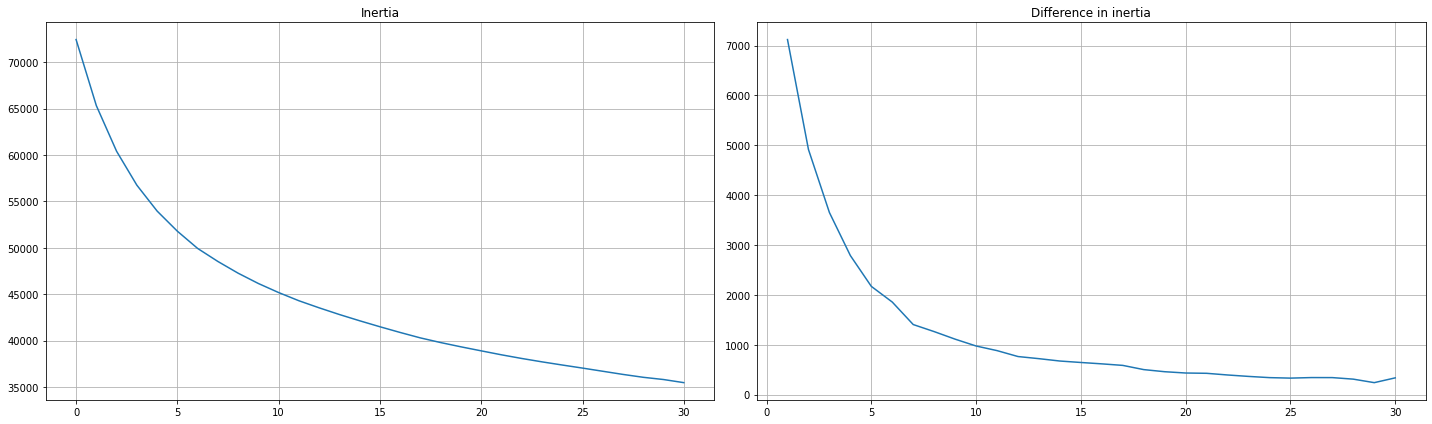

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.plot(inertias)
plt.grid(True)
plt.title("Inertia")

plt.subplot(122)
plt.plot(diffs)
# plt.plot([0, 7], [diffs[5], diffs[5]], ':k')
# plt.plot([7, 7], [0, diffs[5]], ':k')
# plt.plot([0, 8], [diffs[6], diffs[6]], ':k')
# plt.plot([8, 8], [0, diffs[6]], ':k')
plt.grid(True)
# plt.xlim([2, vector_size+1])
plt.title("Difference in inertia")

plt.tight_layout()
plt.show()

In [ ]:
scores.iloc[5]

n_clusters        7.000000
inertias      51792.554688
diffs          2170.757812
Name: 5, dtype: float64